In [287]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import metpy.io as mtio
import metpy.calc as mtcl
import metpy.units as mtun
import pandas as pd
from tqdm import tqdm
import calendar
import math
import concurrent.futures
import requests
from glob import glob
import optuna
from optuna.samplers import TPESampler

sns.set()

## Preparing Train-Valid. data

In [42]:
data_dir = Path(os.getcwd()).parent/"data"/"interm"
train_val = pl.read_csv("merged_train_val.csv", null_values="NA")

In [43]:
train_val.head()

flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera
str,str,str,str,str,i64,i64,i64,f64,f64,i64,f64,f64,str,str,f64,str,f64,str,f64,str,f64,i64,f64,f64,f64,f64,f64,i64
"""504a62621cd231…","""2022-06-01T01:…","""SBCF""","""SBFL""","""http://satelit…",0,1,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362,0.24016,0.031169,0.063786,0
"""b0fd0f83644625…","""2022-06-01T01:…","""SBPA""","""SBFL""","""http://satelit…",0,1,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362,0.000376,0.0,0.0,0
"""1210f0ca07ddca…","""2022-06-01T01:…","""SBSP""","""SBCF""","""http://satelit…",0,0,828,21.0,14.0,10000,2.094395,6.0,null,null,null,null,null,null,null,null,null,0,30.061523,0.910229,0.272527,0.084537,0.091209,0
"""b25032f34507cc…","""2022-06-01T01:…","""SBGR""","""SBCT""","""http://satelit…",0,0,908,10.0,10.0,7000,1.745329,6.0,null,"""BKN""",400.0,"""OVC""",1200.0,null,null,null,null,8,30.091053,0.902375,0.437748,0.112204,0.067739,0
"""00762a9892ecba…","""2022-06-01T01:…","""SBSP""","""SBSV""","""http://satelit…",0,1,6,27.0,21.0,9999,1.919862,8.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.943403,1.000324,0.126246,0.04079,0.042082,0


In [44]:
100 * train_val.null_count() / train_val.shape[0]

flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,1.387951,0.0,0.0,0.772868,0.917899,1.070489,0.781372,6.036499,0.774758,99.069818,28.728405,30.744193,59.273712,59.273712,87.371444,87.371444,99.167608,99.167608,0.772868,0.906561,0.918372,1.395982,1.395982,1.395982,0.0


In [45]:
train_val.describe()

statistic,flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera
str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""211679""","""211679""","""211679""","""211679""","""208741""",211679.0,211679.0,210043.0,209736.0,209413.0,210025.0,198901.0,210039.0,"""1969""","""150867""",146600.0,"""86209""",86209.0,"""26732""",26732.0,"""1762""",1762.0,210043.0,209760.0,209735.0,208724.0,208724.0,208724.0,211679.0
"""null_count""","""0""","""0""","""0""","""0""","""2938""",0.0,0.0,1636.0,1943.0,2266.0,1654.0,12778.0,1640.0,"""209710""","""60812""",65079.0,"""125470""",125470.0,"""184947""",184947.0,"""209917""",209917.0,1636.0,1919.0,1944.0,2955.0,2955.0,2955.0,0.0
"""mean""",null,null,null,null,null,0.317188,0.224302,511.446018,21.702393,16.034487,9416.891403,2.773447,7.039583,null,null,2155.590723,null,4661.05395,null,6532.174921,null,7974.233825,3.719286,30.025968,0.945242,0.047698,0.012386,0.067505,0.017413
"""std""",null,null,null,null,null,0.465382,0.417123,413.112165,5.092171,4.619867,1625.669887,1.714624,3.786628,null,null,1211.647897,null,3039.177703,null,2888.791446,null,2043.361603,2.914659,0.171431,0.04568,0.086169,0.039613,0.110413,0.130805
"""min""","""0000f76a51b99b…","""2022-06-01T01:…","""SBBR""","""SBBR""","""http://satelit…",0.0,0.0,3.0,1.0,-7.0,50.0,0.0,0.0,"""14.0""","""BKN""",0.0,"""BKN""",200.0,"""BKN""",500.0,"""BKN""",2300.0,0.0,2.982528,0.084414,0.0,0.0,0.0,0.0
"""25%""",null,null,null,null,null,0.0,0.0,5.0,18.0,13.0,9999.0,1.570796,4.0,null,null,1100.0,null,2100.0,null,4000.0,null,7000.0,0.0,29.943403,0.91114,0.0,0.0,0.0,0.0
"""50%""",null,null,null,null,null,0.0,0.0,750.0,22.0,17.0,9999.0,2.443461,7.0,null,null,2000.0,null,4000.0,null,7000.0,null,8000.0,4.0,30.031993,0.920669,0.000289,0.0,0.015053,0.0
"""75%""",null,null,null,null,null,1.0,0.0,828.0,26.0,20.0,10000.0,3.665191,9.0,null,null,3000.0,null,7000.0,null,10000.0,null,10000.0,6.0,30.120583,0.998707,0.06117,0.000057,0.089308,0.0
"""max""","""ffffd4331f8b78…","""2023-02-16T13:…","""SBSV""","""SBSV""","""http://satelit…",1.0,1.0,1061.0,38.0,26.0,10000.0,6.283185,35.0,"""45.0""","""VV""",9000.0,"""SCT""",10000.0,"""SCT""",10000.0,"""OVC""",10000.0,10.0,30.534003,1.020413,0.832625,0.634029,0.840394,1.0


In [46]:
keep = [
    "hora_ref", "origem", "destino", "prev_troca_cabeceira", "troca_cabeceira_hora_anterior", 
    "elevation", "air_temperature", "dew_point_temp", "visibility", "wind_direction_rad",	
    "wind_speed", "cloud_coverage_oktas", "altimeter", "pressure_station_level_atm", 
    "sat_yellow_green", "sat_purple_red", "sat_blue", "espera"
]
train_val = train_val[keep]

In [47]:
train_val = train_val.with_columns(
    pl.col("hora_ref").cast(pl.Datetime)
)

In [48]:
train_val

hora_ref,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera
datetime[μs],str,str,i64,i64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64
2022-06-01 01:00:00,"""SBCF""","""SBFL""",0,1,5,14.0,7.0,9999,2.96706,9.0,6,30.120583,1.006362,0.24016,0.031169,0.063786,0
2022-06-01 01:00:00,"""SBPA""","""SBFL""",0,1,5,14.0,7.0,9999,2.96706,9.0,6,30.120583,1.006362,0.000376,0.0,0.0,0
2022-06-01 01:00:00,"""SBSP""","""SBCF""",0,0,828,21.0,14.0,10000,2.094395,6.0,0,30.061523,0.910229,0.272527,0.084537,0.091209,0
2022-06-01 01:00:00,"""SBGR""","""SBCT""",0,0,908,10.0,10.0,7000,1.745329,6.0,8,30.091053,0.902375,0.437748,0.112204,0.067739,0
2022-06-01 01:00:00,"""SBSP""","""SBSV""",0,1,6,27.0,21.0,9999,1.919862,8.0,2,29.943403,1.000324,0.126246,0.04079,0.042082,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023-02-16 13:00:00,"""SBCT""","""SBSP""",0,0,803,23.0,17.0,9999,6.108652,14.0,4,29.854813,0.906588,0.0,0.0,0.029754,0
2023-02-16 13:00:00,"""SBSP""","""SBRF""",0,0,19,29.0,23.0,9999,1.745329,7.0,6,29.854813,0.995828,0.000055,0.0,0.027563,0
2023-02-16 13:00:00,"""SBSP""","""SBRJ""",0,0,3,29.0,22.0,9999,5.585054,10.0,6,29.677633,0.9918,0.0,0.0,0.027829,0


In [49]:
def sin_col(col, period):
    return np.sin(col / period * 2 * np.pi)

def cos_col(col, period):
    return np.cos(col / period * 2 * np.pi)

In [50]:
avg_n_days = 30.437
train_val = train_val.with_columns(
    sin_col(pl.col("hora_ref").dt.month(), 12).alias("month_sin"),
    sin_col(pl.col("hora_ref").dt.day(), avg_n_days).alias("day_sin"),
    sin_col(pl.col("hora_ref").dt.hour(), 24).alias("hour_sin"),
    cos_col(pl.col("hora_ref").dt.month(), 12).alias("month_cos"),
    cos_col(pl.col("hora_ref").dt.day(), avg_n_days).alias("day_cos"),
    cos_col(pl.col("hora_ref").dt.hour(), 24).alias("hour_cos"),
)
train_val = train_val.select([pl.all().exclude("hora_ref")])

In [51]:
train_val

origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos
str,str,i64,i64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64
"""SBCF""","""SBFL""",0,1,5,14.0,7.0,9999,2.96706,9.0,6,30.120583,1.006362,0.24016,0.031169,0.063786,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926
"""SBPA""","""SBFL""",0,1,5,14.0,7.0,9999,2.96706,9.0,6,30.120583,1.006362,0.000376,0.0,0.0,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926
"""SBSP""","""SBCF""",0,0,828,21.0,14.0,10000,2.094395,6.0,0,30.061523,0.910229,0.272527,0.084537,0.091209,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926
"""SBGR""","""SBCT""",0,0,908,10.0,10.0,7000,1.745329,6.0,8,30.091053,0.902375,0.437748,0.112204,0.067739,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926
"""SBSP""","""SBSV""",0,1,6,27.0,21.0,9999,1.919862,8.0,2,29.943403,1.000324,0.126246,0.04079,0.042082,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SBCT""","""SBSP""",0,0,803,23.0,17.0,9999,6.108652,14.0,4,29.854813,0.906588,0.0,0.0,0.029754,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""SBSP""","""SBRF""",0,0,19,29.0,23.0,9999,1.745329,7.0,6,29.854813,0.995828,0.000055,0.0,0.027563,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""SBSP""","""SBRJ""",0,0,3,29.0,22.0,9999,5.585054,10.0,6,29.677633,0.9918,0.0,0.0,0.027829,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926


In [52]:
train_val = train_val.with_columns(
    sin_col(pl.col("wind_direction_rad"), 2 * np.pi).alias("wind_direction_rad_sin"),
    sin_col(pl.col("wind_direction_rad"), 2 * np.pi).alias("wind_direction_rad_cos")
)
train_val = train_val.select([pl.all().exclude("wind_direction_rad")])

In [53]:
train_val = train_val.with_columns(
    (pl.col("origem") + "_" + pl.col("destino")).alias("rota")
)
train_val

origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota
str,str,i64,i64,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""SBCF""","""SBFL""",0,1,5,14.0,7.0,9999,9.0,6,30.120583,1.006362,0.24016,0.031169,0.063786,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.173648,0.173648,"""SBCF_SBFL"""
"""SBPA""","""SBFL""",0,1,5,14.0,7.0,9999,9.0,6,30.120583,1.006362,0.000376,0.0,0.0,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.173648,0.173648,"""SBPA_SBFL"""
"""SBSP""","""SBCF""",0,0,828,21.0,14.0,10000,6.0,0,30.061523,0.910229,0.272527,0.084537,0.091209,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.866025,0.866025,"""SBSP_SBCF"""
"""SBGR""","""SBCT""",0,0,908,10.0,10.0,7000,6.0,8,30.091053,0.902375,0.437748,0.112204,0.067739,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.984808,0.984808,"""SBGR_SBCT"""
"""SBSP""","""SBSV""",0,1,6,27.0,21.0,9999,8.0,2,29.943403,1.000324,0.126246,0.04079,0.042082,0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.939693,0.939693,"""SBSP_SBSV"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SBCT""","""SBSP""",0,0,803,23.0,17.0,9999,14.0,4,29.854813,0.906588,0.0,0.0,0.029754,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-0.173648,-0.173648,"""SBCT_SBSP"""
"""SBSP""","""SBRF""",0,0,19,29.0,23.0,9999,7.0,6,29.854813,0.995828,0.000055,0.0,0.027563,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.984808,0.984808,"""SBSP_SBRF"""
"""SBSP""","""SBRJ""",0,0,3,29.0,22.0,9999,10.0,6,29.677633,0.9918,0.0,0.0,0.027829,0,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-0.642788,-0.642788,"""SBSP_SBRJ"""


In [54]:
train_val = train_val.select([pl.all().exclude("espera"), pl.col("espera")])
train_val

origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota,espera
str,str,i64,i64,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64
"""SBCF""","""SBFL""",0,1,5,14.0,7.0,9999,9.0,6,30.120583,1.006362,0.24016,0.031169,0.063786,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.173648,0.173648,"""SBCF_SBFL""",0
"""SBPA""","""SBFL""",0,1,5,14.0,7.0,9999,9.0,6,30.120583,1.006362,0.000376,0.0,0.0,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.173648,0.173648,"""SBPA_SBFL""",0
"""SBSP""","""SBCF""",0,0,828,21.0,14.0,10000,6.0,0,30.061523,0.910229,0.272527,0.084537,0.091209,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.866025,0.866025,"""SBSP_SBCF""",0
"""SBGR""","""SBCT""",0,0,908,10.0,10.0,7000,6.0,8,30.091053,0.902375,0.437748,0.112204,0.067739,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.984808,0.984808,"""SBGR_SBCT""",0
"""SBSP""","""SBSV""",0,1,6,27.0,21.0,9999,8.0,2,29.943403,1.000324,0.126246,0.04079,0.042082,1.2246e-16,0.204969,0.258819,-1.0,0.978768,0.965926,0.939693,0.939693,"""SBSP_SBSV""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SBCT""","""SBSP""",0,0,803,23.0,17.0,9999,14.0,4,29.854813,0.906588,0.0,0.0,0.029754,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-0.173648,-0.173648,"""SBCT_SBSP""",0
"""SBSP""","""SBRF""",0,0,19,29.0,23.0,9999,7.0,6,29.854813,0.995828,0.000055,0.0,0.027563,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.984808,0.984808,"""SBSP_SBRF""",0
"""SBSP""","""SBRJ""",0,0,3,29.0,22.0,9999,10.0,6,29.677633,0.9918,0.0,0.0,0.027829,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-0.642788,-0.642788,"""SBSP_SBRJ""",0


In [55]:
train_val.describe()

statistic,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota,espera
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""","""211679""","""211679""",211679.0,211679.0,210043.0,209736.0,209413.0,210025.0,210039.0,210043.0,209760.0,209735.0,208724.0,208724.0,208724.0,211679.0,211679.0,211679.0,211679.0,211679.0,211679.0,198901.0,198901.0,"""211679""",211679.0
"""null_count""","""0""","""0""",0.0,0.0,1636.0,1943.0,2266.0,1654.0,1640.0,1636.0,1919.0,1944.0,2955.0,2955.0,2955.0,0.0,0.0,0.0,0.0,0.0,0.0,12778.0,12778.0,"""0""",0.0
"""mean""",null,null,0.317188,0.224302,511.446018,21.702393,16.034487,9416.891403,7.039583,3.719286,30.025968,0.945242,0.047698,0.012386,0.067505,-0.315196,0.038447,-0.231655,0.158495,0.000778,-0.183138,0.304591,0.304591,null,0.017413
"""std""",null,null,0.465382,0.417123,413.112165,5.092171,4.619867,1625.669887,3.786628,2.914659,0.171431,0.04568,0.086169,0.039613,0.110413,0.569968,0.705382,0.618714,0.742072,0.707787,0.728007,0.640465,0.640465,null,0.130805
"""min""","""SBBR""","""SBBR""",0.0,0.0,3.0,1.0,-7.0,50.0,0.0,0.0,2.982528,0.084414,0.0,0.0,0.0,-1.0,-0.999368,-1.0,-1.0,-0.998983,-1.0,-1.0,-1.0,"""SBBR_SBCF""",0.0
"""25%""",null,null,0.0,0.0,5.0,18.0,13.0,9999.0,4.0,0.0,29.943403,0.91114,0.0,0.0,0.0,-0.866025,-0.651461,-0.866025,-0.5,-0.710474,-0.866025,-0.173648,-0.173648,null,0.0
"""50%""",null,null,0.0,0.0,750.0,22.0,17.0,9999.0,7.0,4.0,30.031993,0.920669,0.000289,0.0,0.015053,-0.5,0.11596,-0.258819,0.5,0.035551,-0.5,0.5,0.5,null,0.0
"""75%""",null,null,1.0,0.0,828.0,26.0,20.0,10000.0,9.0,6.0,30.120583,0.998707,0.06117,0.000057,0.089308,1.2246e-16,0.735043,0.258819,0.866025,0.678021,0.5,0.866025,0.866025,null,0.0
"""max""","""SBSV""","""SBSV""",1.0,1.0,1061.0,38.0,26.0,10000.0,35.0,10.0,30.534003,1.020413,0.832625,0.634029,0.840394,0.866025,0.996748,1.0,1.0,0.995934,1.0,1.0,1.0,"""SBSV_SBSP""",1.0


In [56]:
train_val = train_val.to_pandas()

In [57]:
train_val

,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,...,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota,espera
0,SBCF,SBFL,0,1,5.0,14.0,7.0,9999.0,9.0,6.0,...,1.224647e-16,0.204969,0.258819,-1.0,0.978768,0.965926,1.736482e-01,1.736482e-01,SBCF_SBFL,0
1,SBPA,SBFL,0,1,5.0,14.0,7.0,9999.0,9.0,6.0,...,1.224647e-16,0.204969,0.258819,-1.0,0.978768,0.965926,1.736482e-01,1.736482e-01,SBPA_SBFL,0
2,SBSP,SBCF,0,0,828.0,21.0,14.0,10000.0,6.0,0.0,...,1.224647e-16,0.204969,0.258819,-1.0,0.978768,0.965926,8.660254e-01,8.660254e-01,SBSP_SBCF,0
3,SBGR,SBCT,0,0,908.0,10.0,10.0,7000.0,6.0,8.0,...,1.224647e-16,0.204969,0.258819,-1.0,0.978768,0.965926,9.848078e-01,9.848078e-01,SBGR_SBCT,0
4,SBSP,SBSV,0,1,6.0,27.0,21.0,9999.0,8.0,2.0,...,1.224647e-16,0.204969,0.258819,-1.0,0.978768,0.965926,9.396926e-01,9.396926e-01,SBSP_SBSV,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211674,SBCT,SBSP,0,0,803.0,23.0,17.0,9999.0,14.0,4.0,...,8.660254e-01,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-1.736482e-01,-1.736482e-01,SBCT_SBSP,0
211675,SBSP,SBRF,0,0,19.0,29.0,23.0,9999.0,7.0,6.0,...,8.660254e-01,-0.160628,-0.258819,0.5,-0.987015,-0.965926,9.848078e-01,9.848078e-01,SBSP_SBRF,0
211676,SBSP,SBRJ,0,0,3.0,29.0,22.0,9999.0,10.0,6.0,...,8.660254e-01,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-6.427876e-01,-6.427876e-01,SBSP_SBRJ,0
211677,SBRJ,SBKP,0,0,661.0,24.0,19.0,9999.0,12.0,2.0,...,8.660254e-01,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-2.449294e-16,-2.449294e-16,SBRJ_SBKP,0


In [58]:
train_val["origem"] = train_val["origem"].astype("category")
train_val["destino"] = train_val["destino"].astype("category")
train_val["rota"] = train_val["rota"].astype("category")

In [59]:
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   origem                         211679 non-null  category
 1   destino                        211679 non-null  category
 2   prev_troca_cabeceira           211679 non-null  int64   
 3   troca_cabeceira_hora_anterior  211679 non-null  int64   
 4   elevation                      210043 non-null  float64 
 5   air_temperature                209736 non-null  float64 
 6   dew_point_temp                 209413 non-null  float64 
 7   visibility                     210025 non-null  float64 
 8   wind_speed                     210039 non-null  float64 
 9   cloud_coverage_oktas           210043 non-null  float64 
 10  altimeter                      209760 non-null  float64 
 11  pressure_station_level_atm     209735 non-null  float64 
 12  sat_yellow_green

## Preparing test data

In [60]:
test = pl.read_csv(data_dir / "test.csv", null_values="NA")
test

flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera
str,str,str,str,str,str,str,i64,i64,str
"""45e7978b9d88f9…","""2023-02-16T13:…","""SBGL""","""SBKP""","""http://satelit…","""METAF SBKP 161…","""METAR SBKP 161…",0,0,null
"""16ed22b3755aa9…","""2023-02-16T13:…","""SBGR""","""SBCF""","""http://satelit…",null,"""METAR SBCF 161…",0,0,null
"""b548d2c700496e…","""2023-02-16T13:…","""SBSP""","""SBSV""","""http://satelit…",null,"""METAR SBSV 161…",0,1,null
"""e4cc2545104bcf…","""2023-02-16T13:…","""SBGR""","""SBBR""","""http://satelit…",null,"""METAR SBBR 161…",0,0,null
"""ace87fdae88435…","""2023-02-16T14:…","""SBPA""","""SBSP""","""http://satelit…","""METAF SBSP 161…","""METAR SBSP 161…",0,1,null
…,…,…,…,…,…,…,…,…,…
"""8ca8c4d16e592d…","""2023-05-31T23:…","""SBCT""","""SBSP""","""http://satelit…","""METAF SBSP 312…","""METAR SBSP 312…",0,0,null
"""afde50d413c237…","""2023-05-31T23:…","""SBCT""","""SBKP""","""http://satelit…","""METAF SBKP 312…","""METAR SBKP 312…",0,0,null
"""faeb2f6e744c60…","""2023-05-31T23:…","""SBGL""","""SBKP""","""http://satelit…","""METAF SBKP 312…","""METAR SBKP 312…",0,0,null


In [61]:
test = test.with_columns(
    pl.col("hora_ref").cast(pl.Datetime)
)

In [62]:
test = test.with_columns(
    pl.col("metar").fill_null("")
)

In [23]:
def get_parsed_metars(dataset):
    n = dataset.shape[0]
    elevs = []
    temps = []
    dew_pts = []
    visibs = []
    wind_dirs = []
    wind_spds = []
    wind_gusts = []
    skyc1s = []
    skylev1s = []
    skyc2s = []
    skylev2s = []
    skyc3s = []
    skylev3s = []
    skyc4s = []
    skylev4s = []
    cloud_covs = []
    altimeters = []
    pressures = [] # mtcl.altimeter_to_sea_level_pressure

    for i in tqdm(range(n)):
        metar = dataset["metar"][i]
        hora_ref = dataset["hora_ref"][i]
        if metar == "":
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
            continue
        try:
            metar = metar.replace(" COR ", " ")
            metar = metar.replace(" AUTO ", " ")
            metar = metar.replace(" AO1 ", " ")
            metar = metar.replace(" AO2 ", " ")
            metar = mtio.metar.parse_metar(metar, hora_ref.year, hora_ref.month)
            elevs.append(None if math.isnan(metar.elevation) else metar.elevation)
            temps.append(None if math.isnan(metar.temperature) else metar.temperature)
            dew_pts.append(None if math.isnan(metar.dewpoint) else metar.dewpoint)
            visibs.append(None if math.isnan(metar.visibility) else metar.visibility)
            wind_dirs.append(None if math.isnan(metar.wind_direction) else np.deg2rad(metar.wind_direction))
            wind_spds.append(None if math.isnan(metar.wind_speed) else metar.wind_speed)
            wind_gusts.append(None if math.isnan(metar.wind_gust) else metar.wind_gust)
            skyc1s.append(None if type(metar.skyc1) != str else metar.skyc1)
            skylev1s.append(None if math.isnan(metar.skylev1) else metar.skylev1)
            skyc2s.append(None if type(metar.skyc2) != str else metar.skyc2)
            skylev2s.append(None if math.isnan(metar.skylev2) else metar.skylev2)
            skyc3s.append(None if type(metar.skyc3) != str else metar.skyc3)
            skylev3s.append(None if math.isnan(metar.skylev3) else metar.skylev3)
            skyc4s.append(None if type(metar.skyc4) != str else metar.skyc4)
            skylev4s.append(None if math.isnan(metar.skylev4) else metar.skylev4)
            cloud_covs.append(None if math.isnan(metar.cloudcover) else metar.cloudcover)
            altimeters.append(None if math.isnan(metar.altimeter) else metar.altimeter)
            if not (math.isnan(metar.altimeter) or math.isnan(metar.elevation) or math.isnan(metar.temperature)):
                pressures.append(mtcl.altimeter_to_station_pressure(
                    mtun.pint.Quantity(metar.altimeter, "inHg"), 
                    mtun.pint.Quantity(metar.elevation, "meters")
                ).to("hPa").magnitude / 1_013.25) # convert to 'atm'
            else:
                pressures.append(None)
        except Exception as e:
            print(e)
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
    return elevs, temps, dew_pts, visibs, wind_dirs, wind_spds, wind_gusts, skyc1s, skylev1s, \
            skyc2s, skylev2s, skyc3s, skylev3s, skyc4s, skylev4s, cloud_covs, altimeters, pressures

In [24]:
columns = [
    "elevation", "air_temperature", "dew_point_temp", "visibility", "wind_direction_rad", "wind_speed", "wind_gust", 
    "low_cloud_type", "low_cloud_level", "medium_cloud_type", "medium_cloud_level", "high_cloud_type", 
    "high_cloud_level", "highest_cloud_type", "highest_cloud_level", "cloud_coverage_oktas", "altimeter", "pressure_station_level_atm"
]
metar_data = get_parsed_metars(test)
metar_data = pl.DataFrame(metar_data, schema=columns)
metar_data

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 90720/90720 [02:04<00:00, 727.35it/s]


elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm
i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64
661,24.0,19.0,9999,6.283185,12.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.854813,0.922252
828,23.0,19.0,9999,3.141593,5.0,null,"""FEW""",4000.0,"""SCT""",5000.0,null,null,null,null,4,29.972933,0.907496
6,30.0,24.0,9999,0.698132,7.0,null,"""SCT""",2300.0,null,null,null,null,null,null,4,29.854813,0.997365
1061,24.0,19.0,9999,5.235988,3.0,null,"""FEW""",1100.0,"""SCT""",7000.0,null,null,null,null,4,30.002463,0.883133
803,23.0,18.0,9999,5.934119,13.0,null,"""BKN""",2100.0,null,null,null,null,null,null,6,29.854813,0.906588
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
803,16.0,14.0,9999,3.490659,7.0,null,"""SCT""",900.0,"""OVC""",1100.0,null,null,null,null,8,30.209173,0.917545
661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435
661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435


In [63]:
test = pl.concat([test.drop("metar", "metaf"), metar_data], how="horizontal")

In [64]:
test = test.with_columns(
    sin_col(pl.col("hora_ref").dt.month(), 12).alias("month_sin"),
    sin_col(pl.col("hora_ref").dt.day(), avg_n_days).alias("day_sin"),
    sin_col(pl.col("hora_ref").dt.hour(), 24).alias("hour_sin"),
    cos_col(pl.col("hora_ref").dt.month(), 12).alias("month_cos"),
    cos_col(pl.col("hora_ref").dt.day(), avg_n_days).alias("day_cos"),
    cos_col(pl.col("hora_ref").dt.hour(), 24).alias("hour_cos"),
)
test = test.select([pl.all().exclude("hora_ref")])
test

flightid,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos
str,str,str,str,i64,i64,str,i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64
"""45e7978b9d88f9…","""SBGL""","""SBKP""","""http://satelit…",0,0,null,661,24.0,19.0,9999,6.283185,12.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.854813,0.922252,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""16ed22b3755aa9…","""SBGR""","""SBCF""","""http://satelit…",0,0,null,828,23.0,19.0,9999,3.141593,5.0,null,"""FEW""",4000.0,"""SCT""",5000.0,null,null,null,null,4,29.972933,0.907496,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""b548d2c700496e…","""SBSP""","""SBSV""","""http://satelit…",0,1,null,6,30.0,24.0,9999,0.698132,7.0,null,"""SCT""",2300.0,null,null,null,null,null,null,4,29.854813,0.997365,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""e4cc2545104bcf…","""SBGR""","""SBBR""","""http://satelit…",0,0,null,1061,24.0,19.0,9999,5.235988,3.0,null,"""FEW""",1100.0,"""SCT""",7000.0,null,null,null,null,4,30.002463,0.883133,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926
"""ace87fdae88435…","""SBPA""","""SBSP""","""http://satelit…",0,1,null,803,23.0,18.0,9999,5.934119,13.0,null,"""BKN""",2100.0,null,null,null,null,null,null,6,29.854813,0.906588,0.866025,-0.160628,-0.5,0.5,-0.987015,-0.866025
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""8ca8c4d16e592d…","""SBCT""","""SBSP""","""http://satelit…",0,0,null,803,16.0,14.0,9999,3.490659,7.0,null,"""SCT""",900.0,"""OVC""",1100.0,null,null,null,null,8,30.209173,0.917545,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926
"""afde50d413c237…","""SBCT""","""SBKP""","""http://satelit…",0,0,null,661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926
"""faeb2f6e744c60…","""SBGL""","""SBKP""","""http://satelit…",0,0,null,661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926


In [65]:
urls = test["url_img_satelite"].unique().to_list()
image_dir = data_dir / "images"
len(urls)

2422

In [66]:
"""image_dir.mkdir(parents=True, exist_ok=True)
if len(glob(str(image_dir/"*"))) < 6044 + len(urls) - 1:
    def download_file(url):
        try:
            response = requests.get(url)
            filename = image_dir / url.split('/')[-1]
            with open(filename, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        return 0
    
    # Use ThreadPoolExecutor for parallel downloads
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        res = list(tqdm(executor.map(download_file, urls), total=len(urls)))
    print("All files downloaded successfully.")"""

'image_dir.mkdir(parents=True, exist_ok=True)\nif len(glob(str(image_dir/"*"))) < 6044 + len(urls) - 1:\n    def download_file(url):\n        try:\n            response = requests.get(url)\n            filename = image_dir / url.split(\'/\')[-1]\n            with open(filename, \'wb\') as f:\n                f.write(response.content)\n        except Exception as e:\n            print(f"Error downloading {url}: {e}")\n        return 0\n    \n    # Use ThreadPoolExecutor for parallel downloads\n    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:\n        res = list(tqdm(executor.map(download_file, urls), total=len(urls)))\n    print("All files downloaded successfully.")'

In [67]:
"""def to_image_coords(lat, lon):
    m, M = 1004, 2058
    m1, M1 = 808, 1744
    x0, x1 = -30, -75
    y0, y1 = 5, -35
    px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))
    py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))
    return px, py"""

'def to_image_coords(lat, lon):\n    m, M = 1004, 2058\n    m1, M1 = 808, 1744\n    x0, x1 = -30, -75\n    y0, y1 = 5, -35\n    px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))\n    py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))\n    return px, py'

In [68]:
"""def get_masked_roi(image, ori, dst):
    def to_image_coords(lat, lon):
        m, M = 1004, 2058
        m1, M1 = 808, 1744
        x0, x1 = -30, -75
        y0, y1 = 5, -35
        px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))
        py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))
        return px, py
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    m, M = 1004, 2058
    m1, M1 = 808, 1744
    map = gray[m1:M1, m:M]
    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)
    map = cv2.morphologyEx(map, cv2.MORPH_ERODE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=3)
    _, map = cv2.threshold(255 - map, 130, 255, cv2.THRESH_BINARY)
    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=10)
    map = cv2.morphologyEx(map, cv2.MORPH_OPEN, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=10)
    masked_img = img.copy()
    masked_img[m1:M1, m:M] = np.uint8(cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3)), iterations=3)[m1:M1, m:M])
    masked_img[m1:M1, m:M] = masked_img[m1:M1, m:M] * (map / map.max())[..., np.newaxis]

    ori = to_image_coords(*ori)
    dst = to_image_coords(*dst)
    if ori[1] < dst[1]:
        angle = np.rad2deg(np.arctan2(-(dst[1] - ori[1]), -(dst[0] - ori[0])))
    else:
        angle = np.rad2deg(np.arctan2((dst[1] - ori[1]), (dst[0] - ori[0])))
    image_center = tuple(np.array(masked_img.shape[:2][::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated = cv2.warpAffine(masked_img, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    ct = np.cos(np.deg2rad(angle))
    st = np.sin(np.deg2rad(angle))
    ax = ori[0] * ct + ori[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
    ay = -ori[0] * st + ori[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
    nori = int(ax), int(ay)
    ax = dst[0] * ct + dst[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
    ay = -dst[0] * st + dst[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
    ndst = int(ax), int(ay)

    half_b = 35
    if ndst[0] < nori[0]:
        d = nori[0] - ndst[0]
        box = [ndst[0] - half_b, ndst[1] - half_b, d + 2 * half_b, 2 * half_b]
    else:
        d = ndst[0] - nori[0]
        box = [nori[0] - half_b, nori[1] - half_b, d + 2 * half_b, 2 * half_b]
    return rotated[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]"""

'def get_masked_roi(image, ori, dst):\n    def to_image_coords(lat, lon):\n        m, M = 1004, 2058\n        m1, M1 = 808, 1744\n        x0, x1 = -30, -75\n        y0, y1 = 5, -35\n        px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))\n        py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))\n        return px, py\n    \n    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n    m, M = 1004, 2058\n    m1, M1 = 808, 1744\n    map = gray[m1:M1, m:M]\n    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)\n    map = cv2.morphologyEx(map, cv2.MORPH_ERODE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=3)\n    _, map = cv2.threshold(255 - map, 130, 255, cv2.THRESH_BINARY)\n    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=10)\n    map = cv2.morphologyEx(map, cv2.MORPH_OPEN, kernel=cv2.getStructuringElement(

In [69]:
"""def color_proportions(roi):
    h, s, v = cv2.split(cv2.cvtColor(roi, cv2.COLOR_RGB2HSV))
    yellow_green = (h > 35) * (h < 85) * (s > 50)
    purple_red = ((h < 34) + (h > 130)) * (s > 50)
    blue = (h > 90) * (h < 130) * (s > 50)
    return list(color_mask.sum() / color_mask.size for color_mask in [yellow_green, purple_red, blue])"""

'def color_proportions(roi):\n    h, s, v = cv2.split(cv2.cvtColor(roi, cv2.COLOR_RGB2HSV))\n    yellow_green = (h > 35) * (h < 85) * (s > 50)\n    purple_red = ((h < 34) + (h > 130)) * (s > 50)\n    blue = (h > 90) * (h < 130) * (s > 50)\n    return list(color_mask.sum() / color_mask.size for color_mask in [yellow_green, purple_red, blue])'

In [70]:
airport_data = pl.read_csv(data_dir / "airports.csv")
airport_data

ICAO,lat,lon,n_pistas,desig_pista1,desig_pista2
str,f64,f64,i64,str,str
"""SBCF""",-19.63571,-43.96693,1,"""16/34""","""NA"""
"""SBSP""",-23.62695,-46.65503,2,"""17R/35L""","""17L/35R"""
"""SBGR""",-23.43227,-46.46948,2,"""10L/28R""","""10R/28L"""
"""SBKP""",-23.0074,-47.1345,1,"""15/33""","""NA"""
"""SBRF""",-8.12598,-34.92332,1,"""18/36""","""NA"""
…,…,…,…,…,…
"""SBBR""",-15.8712,-47.91933,2,"""11R/29L""","""11L/29R"""
"""SBCT""",-25.52882,-49.17316,2,"""15/33""","""11/29"""
"""SBSV""",-12.91095,-38.33108,2,"""10/28""","""17/35"""


In [71]:
"""columns = [
    "sat_yellow_green", "sat_purple_red", "sat_blue"
]

yellow_green, purple_red, blue = [], [], []
for i in tqdm(range(test.shape[0])):
    try:
        url = test["url_img_satelite"][i]
        origem = test["origem"][i]
        origem = airport_data.filter(pl.col("ICAO") == origem)[["lat", "lon"]].to_numpy()[0].tolist()
        destino = test["destino"][i]
        destino = airport_data.filter(pl.col("ICAO") == destino)[["lat", "lon"]].to_numpy()[0].tolist()
        filename = url.split("/")[-1]
        path = image_dir / filename
        img = mpimg.imread(path)
        roi = get_masked_roi(img, origem, destino)
        yg, pr, bb = color_proportions(roi)
        yellow_green.append(yg)
        purple_red.append(pr)
        blue.append(bb)
    except:
        yellow_green.append(None)
        purple_red.append(None)
        blue.append(None)"""

'columns = [\n    "sat_yellow_green", "sat_purple_red", "sat_blue"\n]\n\nyellow_green, purple_red, blue = [], [], []\nfor i in tqdm(range(test.shape[0])):\n    try:\n        url = test["url_img_satelite"][i]\n        origem = test["origem"][i]\n        origem = airport_data.filter(pl.col("ICAO") == origem)[["lat", "lon"]].to_numpy()[0].tolist()\n        destino = test["destino"][i]\n        destino = airport_data.filter(pl.col("ICAO") == destino)[["lat", "lon"]].to_numpy()[0].tolist()\n        filename = url.split("/")[-1]\n        path = image_dir / filename\n        img = mpimg.imread(path)\n        roi = get_masked_roi(img, origem, destino)\n        yg, pr, bb = color_proportions(roi)\n        yellow_green.append(yg)\n        purple_red.append(pr)\n        blue.append(bb)\n    except:\n        yellow_green.append(None)\n        purple_red.append(None)\n        blue.append(None)'

In [72]:
"""image_color_data = pl.DataFrame([yellow_green, purple_red, blue], schema=columns)
image_color_data.write_csv("test_image_color_data.csv", null_value="NA")"""

'image_color_data = pl.DataFrame([yellow_green, purple_red, blue], schema=columns)\nimage_color_data.write_csv("test_image_color_data.csv", null_value="NA")'

In [73]:
# metar_data.write_csv("test_metar_data.csv", null_value="NA")

In [74]:
image_color_data = pl.read_csv("test_image_color_data.csv", null_values="NA")

In [75]:
test = pl.concat([test.drop("url_img_satelite"), image_color_data], how="horizontal")

In [76]:
test

flightid,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,sat_yellow_green,sat_purple_red,sat_blue
str,str,str,i64,i64,str,i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""45e7978b9d88f9…","""SBGL""","""SBKP""",0,0,null,661,24.0,19.0,9999,6.283185,12.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.854813,0.922252,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.026619
"""16ed22b3755aa9…","""SBGR""","""SBCF""",0,0,null,828,23.0,19.0,9999,3.141593,5.0,null,"""FEW""",4000.0,"""SCT""",5000.0,null,null,null,null,4,29.972933,0.907496,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.06112
"""b548d2c700496e…","""SBSP""","""SBSV""",0,1,null,6,30.0,24.0,9999,0.698132,7.0,null,"""SCT""",2300.0,null,null,null,null,null,null,4,29.854813,0.997365,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.029273
"""e4cc2545104bcf…","""SBGR""","""SBBR""",0,0,null,1061,24.0,19.0,9999,5.235988,3.0,null,"""FEW""",1100.0,"""SCT""",7000.0,null,null,null,null,4,30.002463,0.883133,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.016904
"""ace87fdae88435…","""SBPA""","""SBSP""",0,1,null,803,23.0,18.0,9999,5.934119,13.0,null,"""BKN""",2100.0,null,null,null,null,null,null,6,29.854813,0.906588,0.866025,-0.160628,-0.5,0.5,-0.987015,-0.866025,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""8ca8c4d16e592d…","""SBCT""","""SBSP""",0,0,null,803,16.0,14.0,9999,3.490659,7.0,null,"""SCT""",900.0,"""OVC""",1100.0,null,null,null,null,8,30.209173,0.917545,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.0,0.0,0.0
"""afde50d413c237…","""SBCT""","""SBKP""",0,0,null,661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.0,0.0,0.0
"""faeb2f6e744c60…","""SBGL""","""SBKP""",0,0,null,661,18.0,16.0,9999,3.490659,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.013576,0.0,0.107986


In [77]:
test = test.with_columns(
    sin_col(pl.col("wind_direction_rad"), 2 * np.pi).alias("wind_direction_rad_sin"),
    sin_col(pl.col("wind_direction_rad"), 2 * np.pi).alias("wind_direction_rad_cos")
)
test = test.select([pl.all().exclude("wind_direction_rad")])

In [78]:
test = test.with_columns(
    (pl.col("origem") + "_" + pl.col("destino")).alias("rota")
)
test

flightid,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,elevation,air_temperature,dew_point_temp,visibility,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,sat_yellow_green,sat_purple_red,sat_blue,wind_direction_rad_sin,wind_direction_rad_cos,rota
str,str,str,i64,i64,str,i64,f64,f64,i64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""45e7978b9d88f9…","""SBGL""","""SBKP""",0,0,null,661,24.0,19.0,9999,12.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.854813,0.922252,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.026619,-2.4493e-16,-2.4493e-16,"""SBGL_SBKP"""
"""16ed22b3755aa9…","""SBGR""","""SBCF""",0,0,null,828,23.0,19.0,9999,5.0,null,"""FEW""",4000.0,"""SCT""",5000.0,null,null,null,null,4,29.972933,0.907496,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.06112,1.2246e-16,1.2246e-16,"""SBGR_SBCF"""
"""b548d2c700496e…","""SBSP""","""SBSV""",0,1,null,6,30.0,24.0,9999,7.0,null,"""SCT""",2300.0,null,null,null,null,null,null,4,29.854813,0.997365,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.029273,0.642788,0.642788,"""SBSP_SBSV"""
"""e4cc2545104bcf…","""SBGR""","""SBBR""",0,0,null,1061,24.0,19.0,9999,3.0,null,"""FEW""",1100.0,"""SCT""",7000.0,null,null,null,null,4,30.002463,0.883133,0.866025,-0.160628,-0.258819,0.5,-0.987015,-0.965926,0.0,0.0,0.016904,-0.866025,-0.866025,"""SBGR_SBBR"""
"""ace87fdae88435…","""SBPA""","""SBSP""",0,1,null,803,23.0,18.0,9999,13.0,null,"""BKN""",2100.0,null,null,null,null,null,null,6,29.854813,0.906588,0.866025,-0.160628,-0.5,0.5,-0.987015,-0.866025,0.0,0.0,0.0,-0.34202,-0.34202,"""SBPA_SBSP"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""8ca8c4d16e592d…","""SBCT""","""SBSP""",0,0,null,803,16.0,14.0,9999,7.0,null,"""SCT""",900.0,"""OVC""",1100.0,null,null,null,null,8,30.209173,0.917545,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.0,0.0,0.0,-0.34202,-0.34202,"""SBCT_SBSP"""
"""afde50d413c237…","""SBCT""","""SBKP""",0,0,null,661,18.0,16.0,9999,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.0,0.0,0.0,-0.34202,-0.34202,"""SBCT_SBKP"""
"""faeb2f6e744c60…","""SBGL""","""SBKP""",0,0,null,661,18.0,16.0,9999,4.0,null,"""OVC""",3500.0,null,null,null,null,null,null,8,30.179643,0.932435,0.5,0.11596,-0.258819,-0.866025,0.993254,0.965926,0.013576,0.0,0.107986,-0.34202,-0.34202,"""SBGL_SBKP"""


In [79]:
test = test.to_pandas()
test

,flightid,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,elevation,air_temperature,dew_point_temp,visibility,...,hour_sin,month_cos,day_cos,hour_cos,sat_yellow_green,sat_purple_red,sat_blue,wind_direction_rad_sin,wind_direction_rad_cos,rota
0,45e7978b9d88f934cc06c11b6f0edba7,SBGL,SBKP,0,0,None,661.0,24.0,19.0,9999.0,...,-0.258819,0.500000,-0.987015,-0.965926,0.000000,0.0,0.026619,-2.449294e-16,-2.449294e-16,SBGL_SBKP
1,16ed22b3755aa9196d16fdd2a173c98f,SBGR,SBCF,0,0,None,828.0,23.0,19.0,9999.0,...,-0.258819,0.500000,-0.987015,-0.965926,0.000000,0.0,0.061120,1.224647e-16,1.224647e-16,SBGR_SBCF
2,b548d2c700496e2536d78caf626aee17,SBSP,SBSV,0,1,None,6.0,30.0,24.0,9999.0,...,-0.258819,0.500000,-0.987015,-0.965926,0.000000,0.0,0.029273,6.427876e-01,6.427876e-01,SBSP_SBSV
3,e4cc2545104bcfe978912d39f0960f4e,SBGR,SBBR,0,0,None,1061.0,24.0,19.0,9999.0,...,-0.258819,0.500000,-0.987015,-0.965926,0.000000,0.0,0.016904,-8.660254e-01,-8.660254e-01,SBGR_SBBR
4,ace87fdae884359186e9851c38b146fb,SBPA,SBSP,0,1,None,803.0,23.0,18.0,9999.0,...,-0.500000,0.500000,-0.987015,-0.866025,0.000000,0.0,0.000000,-3.420201e-01,-3.420201e-01,SBPA_SBSP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,8ca8c4d16e592d65cd25d341113aecdf,SBCT,SBSP,0,0,None,803.0,16.0,14.0,9999.0,...,-0.258819,-0.866025,0.993254,0.965926,0.000000,0.0,0.000000,-3.420201e-01,-3.420201e-01,SBCT_SBSP
90716,afde50d413c2374ab53cd3101332f9fc,SBCT,SBKP,0,0,None,661.0,18.0,16.0,9999.0,...,-0.258819,-0.866025,0.993254,0.965926,0.000000,0.0,0.000000,-3.420201e-01,-3.420201e-01,SBCT_SBKP
90717,faeb2f6e744c606aee9e819ea1d62e6b,SBGL,SBKP,0,0,None,661.0,18.0,16.0,9999.0,...,-0.258819,-0.866025,0.993254,0.965926,0.013576,0.0,0.107986,-3.420201e-01,-3.420201e-01,SBGL_SBKP
90718,3992d063be713b35d3bf46b79853880e,SBKP,SBRJ,0,0,None,3.0,20.0,19.0,9999.0,...,-0.258819,-0.866025,0.993254,0.965926,0.006924,0.0,0.118142,-7.660444e-01,-7.660444e-01,SBKP_SBRJ


In [80]:
test = test[list(train_val.columns)].copy()

In [81]:
test.columns == train_val.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [82]:
test

,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,...,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota,espera
0,SBGL,SBKP,0,0,661.0,24.0,19.0,9999.0,12.0,2.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,-2.449294e-16,-2.449294e-16,SBGL_SBKP,None
1,SBGR,SBCF,0,0,828.0,23.0,19.0,9999.0,5.0,4.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,1.224647e-16,1.224647e-16,SBGR_SBCF,None
2,SBSP,SBSV,0,1,6.0,30.0,24.0,9999.0,7.0,4.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,6.427876e-01,6.427876e-01,SBSP_SBSV,None
3,SBGR,SBBR,0,0,1061.0,24.0,19.0,9999.0,3.0,4.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,-8.660254e-01,-8.660254e-01,SBGR_SBBR,None
4,SBPA,SBSP,0,1,803.0,23.0,18.0,9999.0,13.0,6.0,...,0.866025,-0.160628,-0.500000,0.500000,-0.987015,-0.866025,-3.420201e-01,-3.420201e-01,SBPA_SBSP,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,SBCT,SBSP,0,0,803.0,16.0,14.0,9999.0,7.0,8.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,SBCT_SBSP,None
90716,SBCT,SBKP,0,0,661.0,18.0,16.0,9999.0,4.0,8.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,SBCT_SBKP,None
90717,SBGL,SBKP,0,0,661.0,18.0,16.0,9999.0,4.0,8.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,SBGL_SBKP,None
90718,SBKP,SBRJ,0,0,3.0,20.0,19.0,9999.0,4.0,6.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-7.660444e-01,-7.660444e-01,SBKP_SBRJ,None


In [163]:
test["origem"] = test["origem"].astype("category")
test["destino"] = test["destino"].astype("category")
test["rota"] = test["rota"].astype("category")

In [84]:
train_val["n_pistas"] = train_val["destino"].map(
    lambda x: airport_data.filter(pl.col("ICAO") == x)["n_pistas"][0]
)
train_val

,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,cloud_coverage_oktas,...,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,rota,espera,n_pistas
0,SBCF,SBFL,0,1,5.0,14.0,7.0,9999.0,9.0,6.0,...,0.204969,0.258819,-1.0,0.978768,0.965926,1.736482e-01,1.736482e-01,SBCF_SBFL,0,2
1,SBPA,SBFL,0,1,5.0,14.0,7.0,9999.0,9.0,6.0,...,0.204969,0.258819,-1.0,0.978768,0.965926,1.736482e-01,1.736482e-01,SBPA_SBFL,0,2
2,SBSP,SBCF,0,0,828.0,21.0,14.0,10000.0,6.0,0.0,...,0.204969,0.258819,-1.0,0.978768,0.965926,8.660254e-01,8.660254e-01,SBSP_SBCF,0,1
3,SBGR,SBCT,0,0,908.0,10.0,10.0,7000.0,6.0,8.0,...,0.204969,0.258819,-1.0,0.978768,0.965926,9.848078e-01,9.848078e-01,SBGR_SBCT,0,2
4,SBSP,SBSV,0,1,6.0,27.0,21.0,9999.0,8.0,2.0,...,0.204969,0.258819,-1.0,0.978768,0.965926,9.396926e-01,9.396926e-01,SBSP_SBSV,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211674,SBCT,SBSP,0,0,803.0,23.0,17.0,9999.0,14.0,4.0,...,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-1.736482e-01,-1.736482e-01,SBCT_SBSP,0,2
211675,SBSP,SBRF,0,0,19.0,29.0,23.0,9999.0,7.0,6.0,...,-0.160628,-0.258819,0.5,-0.987015,-0.965926,9.848078e-01,9.848078e-01,SBSP_SBRF,0,1
211676,SBSP,SBRJ,0,0,3.0,29.0,22.0,9999.0,10.0,6.0,...,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-6.427876e-01,-6.427876e-01,SBSP_SBRJ,0,2
211677,SBRJ,SBKP,0,0,661.0,24.0,19.0,9999.0,12.0,2.0,...,-0.160628,-0.258819,0.5,-0.987015,-0.965926,-2.449294e-16,-2.449294e-16,SBRJ_SBKP,0,1


In [164]:
ord = ['origem', 'destino', 'rota', 'prev_troca_cabeceira',
       'troca_cabeceira_hora_anterior', 'elevation', 'air_temperature',
       'dew_point_temp', 'visibility', 'wind_speed', 'cloud_coverage_oktas',
       'altimeter', 'pressure_station_level_atm', 'sat_yellow_green',
       'sat_purple_red', 'sat_blue', 'month_sin', 'day_sin', 'hour_sin',
       'month_cos', 'day_cos', 'hour_cos', 'wind_direction_rad_sin',
       'wind_direction_rad_cos', 'n_pistas',  'espera']

In [165]:
train_val = train_val[ord]
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   origem                         211679 non-null  category
 1   destino                        211679 non-null  category
 2   rota                           211679 non-null  category
 3   prev_troca_cabeceira           211679 non-null  int64   
 4   troca_cabeceira_hora_anterior  211679 non-null  int64   
 5   elevation                      210043 non-null  float64 
 6   air_temperature                209736 non-null  float64 
 7   dew_point_temp                 209413 non-null  float64 
 8   visibility                     210025 non-null  float64 
 9   wind_speed                     210039 non-null  float64 
 10  cloud_coverage_oktas           210043 non-null  float64 
 11  altimeter                      209760 non-null  float64 
 12  pressure_station

In [166]:
test["n_pistas"] = test["destino"].map(
    lambda x: airport_data.filter(pl.col("ICAO") == x)["n_pistas"][0]
)
test

,origem,destino,rota,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,...,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,n_pistas,espera
0,SBGL,SBKP,SBGL_SBKP,0,0,661.0,24.0,19.0,9999.0,12.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,-2.449294e-16,-2.449294e-16,1,None
1,SBGR,SBCF,SBGR_SBCF,0,0,828.0,23.0,19.0,9999.0,5.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,1.224647e-16,1.224647e-16,1,None
2,SBSP,SBSV,SBSP_SBSV,0,1,6.0,30.0,24.0,9999.0,7.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,6.427876e-01,6.427876e-01,2,None
3,SBGR,SBBR,SBGR_SBBR,0,0,1061.0,24.0,19.0,9999.0,3.0,...,0.866025,-0.160628,-0.258819,0.500000,-0.987015,-0.965926,-8.660254e-01,-8.660254e-01,2,None
4,SBPA,SBSP,SBPA_SBSP,0,1,803.0,23.0,18.0,9999.0,13.0,...,0.866025,-0.160628,-0.500000,0.500000,-0.987015,-0.866025,-3.420201e-01,-3.420201e-01,2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,SBCT,SBSP,SBCT_SBSP,0,0,803.0,16.0,14.0,9999.0,7.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,2,None
90716,SBCT,SBKP,SBCT_SBKP,0,0,661.0,18.0,16.0,9999.0,4.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,1,None
90717,SBGL,SBKP,SBGL_SBKP,0,0,661.0,18.0,16.0,9999.0,4.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-3.420201e-01,-3.420201e-01,1,None
90718,SBKP,SBRJ,SBKP_SBRJ,0,0,3.0,20.0,19.0,9999.0,4.0,...,0.500000,0.115960,-0.258819,-0.866025,0.993254,0.965926,-7.660444e-01,-7.660444e-01,2,None


In [167]:
test = test[ord]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90720 entries, 0 to 90719
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   origem                         90720 non-null  category
 1   destino                        90720 non-null  category
 2   rota                           90720 non-null  category
 3   prev_troca_cabeceira           90720 non-null  int64   
 4   troca_cabeceira_hora_anterior  90720 non-null  int64   
 5   elevation                      90715 non-null  float64 
 6   air_temperature                90687 non-null  float64 
 7   dew_point_temp                 90687 non-null  float64 
 8   visibility                     90715 non-null  float64 
 9   wind_speed                     90715 non-null  float64 
 10  cloud_coverage_oktas           90715 non-null  float64 
 11  altimeter                      90688 non-null  float64 
 12  pressure_station_level_atm     9

---

In [89]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from catboost import CatBoostClassifier

In [90]:
X = train_val.drop("espera", axis=1)
y = train_val["espera"]

In [236]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [237]:
X_train

,origem,destino,rota,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_speed,...,sat_blue,month_sin,day_sin,hour_sin,month_cos,day_cos,hour_cos,wind_direction_rad_sin,wind_direction_rad_cos,n_pistas
119548,SBCT,SBGR,SBCT_SBGR,0,0,750.0,27.0,19.0,9999.0,6.0,...,0.184390,-0.866025,-0.090089,-0.500000,5.000000e-01,0.995934,0.866025,-1.736482e-01,-1.736482e-01,2
52096,SBCT,SBKP,SBCT_SBKP,0,0,661.0,17.0,12.0,10000.0,10.0,...,0.098043,-0.866025,0.945327,-0.258819,-5.000000e-01,0.326125,-0.965926,9.396926e-01,9.396926e-01,1
60233,SBCF,SBBR,SBCF_SBBR,1,0,1061.0,28.0,7.0,9999.0,4.0,...,0.000000,-0.866025,-0.160628,-0.866025,-5.000000e-01,-0.987015,0.500000,6.427876e-01,6.427876e-01,2
191002,SBRJ,SBPA,SBRJ_SBPA,1,0,3.0,32.0,15.0,9999.0,5.0,...,0.029286,0.500000,-0.999368,-0.866025,8.660254e-01,0.035551,-0.500000,-9.848078e-01,-9.848078e-01,1
51791,SBGR,SBPA,SBGR_SBPA,0,0,3.0,12.0,10.0,9999.0,6.0,...,0.000000,-0.866025,0.945327,0.258819,-5.000000e-01,0.326125,0.965926,1.224647e-16,1.224647e-16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130435,SBBR,SBSP,SBBR_SBSP,1,0,803.0,24.0,16.0,9999.0,6.0,...,NaN,-0.500000,0.616589,-0.866025,8.660254e-01,-0.787285,-0.500000,-5.000000e-01,-5.000000e-01,2
77501,SBKP,SBBR,SBKP_SBBR,1,0,1061.0,21.0,11.0,10000.0,6.0,...,0.000000,-1.000000,0.996748,0.258819,-1.836970e-16,-0.080576,0.965926,1.000000e+00,1.000000e+00,2
35964,SBCT,SBBR,SBCT_SBBR,0,0,1061.0,26.0,7.0,10000.0,10.0,...,0.101630,-0.500000,-0.359526,-0.707107,-8.660254e-01,-0.933135,0.707107,8.660254e-01,8.660254e-01,2
141894,SBRJ,SBSP,SBRJ_SBSP,0,0,803.0,15.0,14.0,9999.0,5.0,...,0.030612,-0.500000,-0.793136,0.258819,8.660254e-01,0.609045,-0.965926,-1.736482e-01,-1.736482e-01,2


In [307]:
cols = list(X_train.columns)[3:]
cols

['prev_troca_cabeceira',
 'troca_cabeceira_hora_anterior',
 'elevation',
 'air_temperature',
 'dew_point_temp',
 'visibility',
 'wind_speed',
 'cloud_coverage_oktas',
 'altimeter',
 'pressure_station_level_atm',
 'sat_yellow_green',
 'sat_purple_red',
 'sat_blue',
 'month_sin',
 'day_sin',
 'hour_sin',
 'month_cos',
 'day_cos',
 'hour_cos',
 'wind_direction_rad_sin',
 'wind_direction_rad_cos',
 'n_pistas']

In [239]:
imp_train = IterativeImputer(max_iter=15, random_state=42)
imp_val = IterativeImputer(max_iter=15, random_state=42)
imp_test = IterativeImputer(max_iter=15, random_state=42, keep_empty_features=True)

In [240]:
X_train_ = X_train.copy()
X_val_ = X_val.copy()
test_ = test.copy()
X_train_[cols] = imp_train.fit_transform(X_train[cols])
X_val_[cols] = imp_val.fit_transform(X_val[cols])
test_[cols] = imp_test.fit_transform(test_[cols])

C:\Users\jgpt\AppData\Local\miniconda3\envs\dsc_wait_prediction\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [241]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169343 entries, 119548 to 98918
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   origem                         169343 non-null  category
 1   destino                        169343 non-null  category
 2   rota                           169343 non-null  category
 3   prev_troca_cabeceira           169343 non-null  float64 
 4   troca_cabeceira_hora_anterior  169343 non-null  float64 
 5   elevation                      169343 non-null  float64 
 6   air_temperature                169343 non-null  float64 
 7   dew_point_temp                 169343 non-null  float64 
 8   visibility                     169343 non-null  float64 
 9   wind_speed                     169343 non-null  float64 
 10  cloud_coverage_oktas           169343 non-null  float64 
 11  altimeter                      169343 non-null  float64 
 12  pressure_station_

In [242]:
X_val_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42336 entries, 142386 to 22906
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   origem                         42336 non-null  category
 1   destino                        42336 non-null  category
 2   rota                           42336 non-null  category
 3   prev_troca_cabeceira           42336 non-null  float64 
 4   troca_cabeceira_hora_anterior  42336 non-null  float64 
 5   elevation                      42336 non-null  float64 
 6   air_temperature                42336 non-null  float64 
 7   dew_point_temp                 42336 non-null  float64 
 8   visibility                     42336 non-null  float64 
 9   wind_speed                     42336 non-null  float64 
 10  cloud_coverage_oktas           42336 non-null  float64 
 11  altimeter                      42336 non-null  float64 
 12  pressure_station_level_atm     4

In [243]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90720 entries, 0 to 90719
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   origem                         90720 non-null  category
 1   destino                        90720 non-null  category
 2   rota                           90720 non-null  category
 3   prev_troca_cabeceira           90720 non-null  float64 
 4   troca_cabeceira_hora_anterior  90720 non-null  float64 
 5   elevation                      90720 non-null  float64 
 6   air_temperature                90720 non-null  float64 
 7   dew_point_temp                 90720 non-null  float64 
 8   visibility                     90720 non-null  float64 
 9   wind_speed                     90720 non-null  float64 
 10  cloud_coverage_oktas           90720 non-null  float64 
 11  altimeter                      90720 non-null  float64 
 12  pressure_station_level_atm     9

In [244]:
cat_features = ["origem", "destino", "rota"]

In [245]:
class_weight = (y_train == 0).sum() / y_train.sum()

In [350]:
def objective_catboost(trial): 
    global X_train_, y_train    
    cv_outer=StratifiedKFold(n_splits=5, random_state=13, shuffle=True)  
    params = {
        'iterations': trial.suggest_int("iterations", 50, 1000, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, step=1e-4),
        'max_depth': trial.suggest_int('max_depth', 1, 8, step=1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5, step=1),
        'random_state': 13,
        'cat_features': cat_features,
        'eval_metric': 'F1',
        'verbose': False, 
        'early_stopping_rounds': 5,
        'scale_pos_weight': class_weight,
        'task_type': "GPU",
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    return -cross_val_score(model, X_train_, y_train, cv=cv_outer, scoring="f1").mean()

In [351]:
sampler = TPESampler(seed = 13)
catboost_study = optuna.create_study(study_name="catboost", direction="minimize", sampler=sampler)
catboost_study.optimize(objective_catboost, n_trials=200)

[I 2024-04-29 00:42:35,009] A new study created in memory with name: catboost
[I 2024-04-29 00:45:10,521] Trial 0 finished with value: -0.1425735867272207 and parameters: {'iterations': 790, 'learning_rate': 0.0245, 'max_depth': 7, 'l2_leaf_reg': 5}. Best is trial 0 with value: -0.1425735867272207.
[I 2024-04-29 00:47:22,015] Trial 1 finished with value: -0.12278189913051214 and parameters: {'iterations': 980, 'learning_rate': 0.0459, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 0 with value: -0.1425735867272207.
[I 2024-04-29 00:47:57,621] Trial 2 finished with value: -0.07415752550960117 and parameters: {'iterations': 660, 'learning_rate': 0.07250000000000001, 'max_depth': 1, 'l2_leaf_reg': 2}. Best is trial 0 with value: -0.1425735867272207.
[I 2024-04-29 00:48:07,039] Trial 3 finished with value: -0.07911001397112878 and parameters: {'iterations': 100, 'learning_rate': 0.0859, 'max_depth': 3, 'l2_leaf_reg': 4}. Best is trial 0 with value: -0.1425735867272207.
[I 2024-04-29 00:4

KeyboardInterrupt: 

In [155]:
b = catboost_study.best_trial.params
b.update({
    'random_state': 1234,
    'cat_features': cat_features,
    'eval_metric': 'F1',
    'verbose': False, 
    'early_stopping_rounds': 5,
    'scale_pos_weight': class_weight,
    'task_type': "GPU",
    'devices': '0'
})

In [156]:
model = CatBoostClassifier(random_state=1, verbose=False,
                           cat_features=cat_features, **b)

In [276]:
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                           verbose=False, cat_features=cat_features, 
                           random_state=1234, scale_pos_weight=class_weight)

In [277]:
model.fit(X_train_, y_train)

In [278]:
y_pred_val = model.predict(X_val_)

In [279]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     41599
           1       0.05      0.72      0.09       737

    accuracy                           0.75     42336
   macro avg       0.52      0.73      0.47     42336
weighted avg       0.98      0.75      0.84     42336



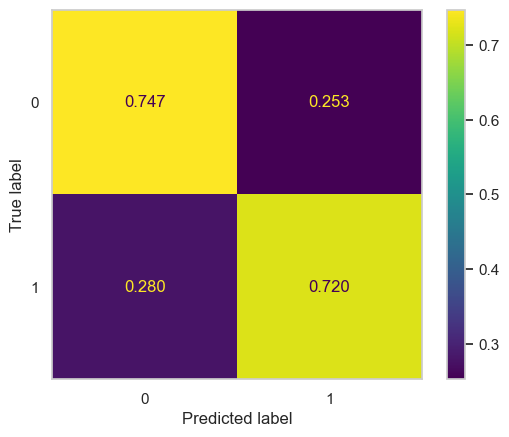

In [280]:
sns.set_style("whitegrid", {'axes.grid' : False})
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, normalize="true", values_format=".3f")

<Axes: >

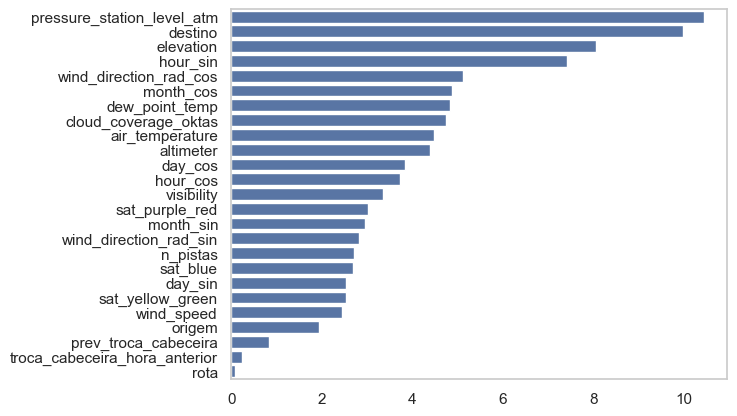

In [281]:
importances = model.feature_importances_
cols = np.array(list(X.columns))
idx = np.argsort(importances)[::-1]
sns.barplot(x=importances[idx], y=cols[idx])

In [282]:
y_pred = model.predict(test_.drop("espera", axis=1))

In [283]:
submission = pl.read_csv(data_dir / "test.csv", null_values="NA")[["flightid"]]

In [284]:
submission = submission.with_columns(pl.Series(name="espera", values=y_pred))
submission

flightid,espera
str,i64
"""45e7978b9d88f9…",0
"""16ed22b3755aa9…",0
"""b548d2c700496e…",0
"""e4cc2545104bcf…",0
"""ace87fdae88435…",1
…,…
"""8ca8c4d16e592d…",0
"""afde50d413c237…",0
"""faeb2f6e744c60…",1


In [285]:
submission.write_csv("2804-cat_full.csv")